# Определение перспективного тарифа для телеком-компании

### Введение

Клиентам оператора сотовой связи предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
В данной работе предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Имеются данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше, т.е. выгоднее для оператора.

Описание тарифов

Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 3 рубля
•	сообщение: 3 рубля
•	1 Гб интернет-трафика: 200 рублей  

Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 1 рубль
•	сообщение: 1 рубль
•	1 Гб интернет-трафика: 150 рублей  

Значения минут и мегабайтов всегда округляются вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

Описание данных 

Таблица users (информация о пользователях):  
•	user_id — уникальный идентификатор пользователя  
•	first_name — имя пользователя  
•	last_name — фамилия пользователя  
•	age — возраст пользователя (годы)  
•	reg_date — дата подключения тарифа (день, месяц, год)  
•	churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
•	city — город проживания пользователя  
•	tariff — название тарифного плана  

Таблица calls (информация о звонках):  
•	id — уникальный номер звонка  
•	call_date — дата звонка  
•	duration — длительность звонка в минутах  
•	user_id — идентификатор пользователя, сделавшего звонок  

Таблица messages (информация о сообщениях):  
•	id — уникальный номер сообщения  
•	message_date — дата сообщения  
•	user_id — идентификатор пользователя, отправившего сообщение  

Таблица internet (информация об интернет-сессиях):  
•	id — уникальный номер сессии  
•	mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
•	session_date — дата интернет-сессии  
•	user_id — идентификатор пользователя  

Таблица tariffs (информация о тарифах):  
•	tariff_name — название тарифа  
•	rub_monthly_fee — ежемесячная абонентская плата в рублях  
•	minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
•	messages_included — количество сообщений в месяц, включённых в абонентскую плату  
•	mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
•	rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
•	rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
•	rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  



Краткий план работы:
1. Изучение общей информации о базе данных
2. Предобработка данных
3. Анализ данных
4. Проверка гипотез
5. Общий вывод

### 1. Изучение общей информации о базе данных

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
# чтение файлов базы данных
calls = pd.read_csv('/datasets/calls.csv')
inet = pd.read_csv('/datasets/internet.csv')
msgs = pd.read_csv('/datasets/messages.csv')
trfs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Теперь изучим файлы базы данных.

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls[calls['duration']==0]['duration'].count()

39613

Выводы по таблице calls (информация о звонках):  
-дата звонка записана в формате 'object', потребуется перевод в формат 'datetime';  
-20% звонков имеют длительность = 0 минут, потребуется обработка этих данных.

In [6]:
inet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [7]:
inet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [8]:
inet[inet['mb_used']==0]['mb_used'].count()

19598

Выводы по таблице inet (информация об интернет-сессиях):  
-дата записана в формате 'object', потребуется перевод в формат 'datetime';  
-13% сессий имеют объем трафика = 0, потребуется обработка этих данных.

In [9]:
msgs.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
msgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Выводы по таблице msgs (информация о сообщениях):  
-дата записана в формате 'object', потребуется перевод в формат 'datetime'.

In [11]:
trfs.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
trfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Выводы по таблице trfs (информация о тарифах):  
-обнаружена опечатка в названии столбца 'mg_per_month_included', переименуем в 'mb_per_month_included';  
-в остальном предобработка данных не требуется.

In [13]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Выводы по таблице users (информация о пользователях):  
-даты записана в формате 'object', потребуется перевод в формат 'datetime';  
-имеются пропуски в 'churn_date' (дата прекращения пользования тарифом), но по условию задания, если значение 'churn_date' пропущено, то тариф ещё действовал на момент выгрузки данных - оставим пропуски пустыми.

#### Общий вывод по изучению базы данных:   
-база данных представлена пятью отдельными файлами;   
-значения даты во всех случаях записаны в формате 'object', потребуется изменение типа данных;   
-имеются нулевые значения длительности звонка и трафика интернет-сессии, потребуется обработка этих значений.

### 2а. Предобработка данных

In [15]:
# переведем календарные даты в тип 'datetime'
calls['call_date']= pd.to_datetime(calls['call_date'])
inet['session_date'] = pd.to_datetime(inet['session_date'])
msgs['message_date']= pd.to_datetime(msgs['message_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

Причиной нулевых значений длительности звонка в базе данных возможно является то, что продолжительность этих звонков входит в предоплаченный пакет. Проверим это предположение, отсортировав звонки каждого пользователя по дате.  Если предположение верно, то звонки нулевой продолжительности будут находится в начале списка по каждому пользователю. Аналогично поступим с интернет-траффиком и таблицей inet.

In [16]:
calls.sort_values(by=['user_id', 'call_date']).head(20)

,id,call_date,duration,user_id
38,1000_38,2018-05-25,0.00,1000
78,1000_78,2018-05-26,10.25,1000
113,1000_113,2018-05-26,6.88,1000
133,1000_133,2018-05-26,4.19,1000
194,1000_194,2018-05-26,13.01,1000
335,1000_335,2018-05-26,1.91,1000
338,1000_338,2018-05-26,10.17,1000
274,1000_274,2018-05-27,3.43,1000
11,1000_11,2018-05-28,18.82,1000
124,1000_124,2018-05-28,0.00,1000


In [17]:
inet.sort_values(by=['user_id', 'session_date']).head(35)

,id,mb_used,session_date,user_id
103,1000_103,0.00,2018-05-26,1000
59,1000_59,363.20,2018-05-28,1000
96,1000_96,544.22,2018-05-28,1000
51,1000_51,628.41,2018-05-31,1000
134,1000_134,717.66,2018-05-31,1000
135,1000_135,517.36,2018-06-01,1000
150,1000_150,1094.05,2018-06-01,1000
17,1000_17,204.14,2018-06-03,1000
37,1000_37,747.58,2018-06-03,1000
162,1000_162,359.04,2018-06-05,1000


Как видим, нулевые значения продолжительности звонков и трафика расположены беспорядочно. Т.е. наше предположение неверно.   
Заменим нулевые значения на медианные соответствующего пользователя.

In [18]:
# замена нулевых значений продолжительности звонка на медианные
def dur_guess(row):
    dur = calls[calls['user_id']==row['user_id']]['duration'].median()
    return dur
calls.loc[calls['duration']==0, 'duration'] = calls[calls['duration']==0].apply(dur_guess, axis=1)
calls[calls['duration']==0]['duration'].count()

0

In [19]:
# замена нулевых значений трафика на медианные
def mb_guess(row):
    mb = inet[inet['user_id']==row['user_id']]['mb_used'].median()
    return mb
inet.loc[inet['mb_used']==0, 'mb_used'] = inet[inet['mb_used']==0].apply(mb_guess, axis=1)
inet[inet['mb_used']==0]['mb_used'].count()

0

In [20]:
# исправим опечатку в названии столбца таблицы тарифов
trfs = trfs.rename(columns={'mg_per_month_included':'mb_per_month_included'})

### 2б. Расчет дополнительных значений для каждого пользователя

### 2б.1. Количество минут разговора по месяцам

In [21]:
# вынесем номер месяца в отдельный столбец
calls['month']=calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,5.81,1000,7
1,1000_1,2018-08-17,5.81,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


In [22]:
# создадим таблицу 'cpm' ("calls per month")
cpm = calls.pivot_table(index=['user_id'], columns=['month'], values='duration', aggfunc = 'sum').reset_index()
cpm.head()

month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,179.11,246.05,353.66,447.97,509.86,403.98,353.90,359.46
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,486.80,481.26
2,1002,NaN,NaN,NaN,NaN,NaN,115.58,230.80,295.76,253.16,246.37,264.50,254.24
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,426.71,1076.57,874.19,893.79,873.90
4,1004,NaN,NaN,NaN,NaN,39.85,181.82,131.98,131.79,140.81,163.85,124.84,146.13


In [23]:
cpm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 13 columns):
user_id    492 non-null int64
1          43 non-null float64
2          82 non-null float64
3          114 non-null float64
4          165 non-null float64
5          205 non-null float64
6          244 non-null float64
7          289 non-null float64
8          337 non-null float64
9          370 non-null float64
10         411 non-null float64
11         444 non-null float64
12         470 non-null float64
dtypes: float64(12), int64(1)
memory usage: 50.1 KB


In [24]:
# т.к. таблица 'cpm' содержит информацию о 492 пользователях, а таблица 'users'- о 500 пользователях, то,
# чтобы обеспечить корректный перенос столбца 'tariff', произведем переиндексацию таблицы 'users'
users1 = users.set_index(['user_id'])

In [25]:
# добавим информацию о тарифе каждого пользователя в таблицу 'cpm'
cpm = cpm.join(users1['tariff'], on='user_id')
cpm.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,NaN,NaN,NaN,NaN,179.11,246.05,353.66,447.97,509.86,403.98,353.90,359.46,ultra
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,486.80,481.26,smart
2,1002,NaN,NaN,NaN,NaN,NaN,115.58,230.80,295.76,253.16,246.37,264.50,254.24,smart
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,426.71,1076.57,874.19,893.79,873.90,ultra
4,1004,NaN,NaN,NaN,NaN,39.85,181.82,131.98,131.79,140.81,163.85,124.84,146.13,ultra


In [26]:
import numpy as np

In [27]:
# добавим 'minutes_included' и 'rub_per_minute', но сохраним таблицу 'cpm' в виде, приведенном выше
# (эта таблица понадобится в Разделе 3.1.)
cpm1=cpm
cpm1['minutes_included']=np.nan
cpm1['rub_per_minute']=np.nan 
def insert(row):
    for i in range(len(trfs)):
        if trfs.loc[i,'tariff_name'] == row['tariff']:
            row['minutes_included']= trfs.loc[i,'minutes_included']
            row['rub_per_minute']=trfs.loc[i,'rub_per_minute']
    return row
cpm1 = cpm1.apply(insert, axis=1)
cpm1.head(10)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,minutes_included,rub_per_minute
0,1000,NaN,NaN,NaN,NaN,179.11,246.05,353.66,447.97,509.86,403.98,353.90,359.460,ultra,3000,1
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,486.80,481.260,smart,500,3
2,1002,NaN,NaN,NaN,NaN,NaN,115.58,230.80,295.76,253.16,246.37,264.50,254.240,smart,500,3
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,426.71,1076.57,874.19,893.79,873.900,ultra,3000,1
4,1004,NaN,NaN,NaN,NaN,39.85,181.82,131.98,131.79,140.81,163.85,124.84,146.130,ultra,3000,1
5,1005,116.69,516.90,663.70,824.76,636.46,648.41,633.03,631.87,505.13,826.57,619.94,694.670,smart,500,3
6,1006,NaN,40.24,324.40,382.99,408.29,483.21,361.76,314.86,373.53,300.60,438.39,390.310,smart,500,3
7,1007,NaN,NaN,NaN,211.42,508.89,598.13,625.09,584.06,735.63,534.70,631.94,507.400,smart,500,3
8,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.845,smart,500,3
9,1009,NaN,NaN,108.91,330.07,192.45,277.99,183.72,271.03,152.02,233.97,313.89,262.740,smart,500,3


In [28]:
import math

In [29]:
# создадим таблицу 'cpm_pay' ежемесячных платежей за минуты свыше включенных в тарифный план (округляя минуты до целых вверх)
cpm_pay = cpm1
def min_extra(row):
    try:
        row[m] = math.ceil(row[m])
    except:
        row[m] = row[m]
    rub = (row[m]-row['minutes_included'])*row['rub_per_minute']
    if rub<0:
        rub = 0
    return rub
for m in range(1,13):
    cpm_pay.loc[:,m] = cpm1.apply(min_extra, axis=1)
cpm_pay.head(10)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,minutes_included,rub_per_minute
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,3000,1
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,smart,500,3
2,1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,500,3
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,3000,1
4,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,3000,1
5,1005,0.0,51.0,492.0,975.0,411.0,447.0,402.0,396.0,18.0,981.0,360.0,585.0,smart,500,3
6,1006,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,500,3
7,1007,NaN,NaN,NaN,0.0,27.0,297.0,378.0,255.0,708.0,105.0,396.0,24.0,smart,500,3
8,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,smart,500,3
9,1009,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,500,3


### 2б.2. Количество сообщений по месяцам.

Аналогично звонкам создадим таблицу 'mpm_pay' ("messages per month pay") о помесячных платежах за сообщения, свыше включенных в пакет тарифа.

In [30]:
# вынесем номер месяца в отдельный столбец
msgs['month']=msgs['message_date'].dt.month
msgs.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [31]:
# создадим таблицу 'mpm' ("messages per month")
mpm = msgs.pivot_table(index=['user_id'], columns=['month'], values='id', aggfunc = 'count').reset_index()
mpm.head()

month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
3,1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
4,1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0


In [32]:
mpm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 13 columns):
user_id    426 non-null int64
1          38 non-null float64
2          66 non-null float64
3          94 non-null float64
4          135 non-null float64
5          174 non-null float64
6          209 non-null float64
7          247 non-null float64
8          292 non-null float64
9          318 non-null float64
10         357 non-null float64
11         383 non-null float64
12         404 non-null float64
dtypes: float64(12), int64(1)
memory usage: 43.4 KB


In [33]:
# добавим информацию о тарифе каждого пользователя в таблицу 'mpm'
mpm = mpm.join(users1['tariff'], on='user_id')
mpm.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,ultra
1,1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,smart
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,ultra
3,1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,ultra
4,1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,smart


In [34]:
# добавим столбцы 'messages_included' и 'rub_per_message', но сохраним таблицу 'mpm' в виде, приведенном выше
# (эта таблица понадобится в Разделе 3.1.)
mpm1=mpm
mpm1['messages_included']=np.nan
mpm1['rub_per_message']=np.nan 
def insert1(row):
    for i in range(len(trfs)):
        if trfs.loc[i,'tariff_name'] == row['tariff']:
            row['messages_included']= trfs.loc[i,'messages_included']
            row['rub_per_message']=trfs.loc[i,'rub_per_message']
    return row
mpm1 = mpm1.apply(insert1, axis=1)
mpm1.head(10)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,messages_included,rub_per_message
0,1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,ultra,1000,1
1,1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,smart,50,3
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,ultra,1000,1
3,1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,ultra,1000,1
4,1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,smart,50,3
5,1007,NaN,NaN,NaN,11.0,39.0,26.0,26.0,27.0,31.0,18.0,21.0,26.0,smart,50,3
6,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,smart,50,3
7,1009,NaN,NaN,2.0,14.0,7.0,14.0,14.0,9.0,12.0,15.0,11.0,12.0,smart,50,3
8,1011,NaN,NaN,4.0,7.0,13.0,13.0,13.0,15.0,10.0,17.0,12.0,6.0,smart,50,3
9,1012,NaN,NaN,2.0,21.0,10.0,15.0,12.0,23.0,14.0,13.0,25.0,15.0,smart,50,3


In [35]:
# создадим таблицу 'mpm_pay' ежемесячных платежей за сообщения свыше включенных в тарифный план
mpm_pay = mpm1
def msg_extra(row):
    rub = (row[m]-row['messages_included'])*row['rub_per_message']
    if rub<0:
        rub = 0
    return rub
for m in range(1,13):
    mpm_pay.loc[:,m] = mpm1.apply(msg_extra, axis=1)
mpm_pay.head(10)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,messages_included,rub_per_message
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000,1
1,1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,50,3
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,1000,1
3,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000,1
4,1005,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0,smart,50,3
5,1007,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,50,3
6,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,smart,50,3
7,1009,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,50,3
8,1011,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,50,3
9,1012,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,50,3


### 2б.3. Интернет-трафик по месяцам.

Аналогично звонкам и сообщениям создадим таблицу 'ipm_pay'("internet per month pay") о помесячных платежах за интернет-трафик, не включенный в пакет тарифа.

In [36]:
# вынесем номер месяца в отдельный столбец
inet['month']=inet['session_date'].dt.month
inet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [37]:
# создадим таблицу 'ipm' ("internet traffic per month")
ipm = inet.pivot_table(index=['user_id'], columns=['month'], values='mb_used', aggfunc = 'sum').reset_index()
ipm.head()

month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,2780.31,25867.87,14530.46,15109.570,15622.55,14702.49,15283.290,10871.25
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21121.100,16055.48
2,1002,NaN,NaN,NaN,NaN,NaN,12958.99,21784.44,23322.360,20294.80,16290.73,21890.690,21116.83
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9099.115,12468.87,14768.14,11890.795,10121.53
4,1004,NaN,NaN,NaN,NaN,13403.98,18576.98,23695.02,29561.330,17551.43,20429.36,17081.460,19486.48


In [38]:
ipm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 13 columns):
user_id    497 non-null int64
1          43 non-null float64
2          80 non-null float64
3          114 non-null float64
4          167 non-null float64
5          207 non-null float64
6          247 non-null float64
7          291 non-null float64
8          340 non-null float64
9          374 non-null float64
10         416 non-null float64
11         449 non-null float64
12         475 non-null float64
dtypes: float64(12), int64(1)
memory usage: 50.6 KB


In [39]:
# добавим информацию о тарифе каждого пользователя в таблицу 'ipm'
ipm = ipm.join(users1['tariff'], on='user_id')
ipm.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,NaN,NaN,NaN,NaN,2780.31,25867.87,14530.46,15109.570,15622.55,14702.49,15283.290,10871.25,ultra
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21121.100,16055.48,smart
2,1002,NaN,NaN,NaN,NaN,NaN,12958.99,21784.44,23322.360,20294.80,16290.73,21890.690,21116.83,smart
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9099.115,12468.87,14768.14,11890.795,10121.53,ultra
4,1004,NaN,NaN,NaN,NaN,13403.98,18576.98,23695.02,29561.330,17551.43,20429.36,17081.460,19486.48,ultra


In [40]:
# добавим столбцы 'mb_per_month_included' и 'rub_per_gb'
ipm1=ipm
ipm1['mb_per_month_included']=np.nan
ipm1['rub_per_gb']=np.nan 
def insert2(row):
    for i in range(len(trfs)):
        if trfs.loc[i,'tariff_name'] == row['tariff']:
            row['mb_per_month_included']= trfs.loc[i,'mb_per_month_included']
            row['rub_per_gb']=trfs.loc[i,'rub_per_gb']
    return row
ipm1 = ipm1.apply(insert2, axis=1)
ipm1.head(10)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,mb_per_month_included,rub_per_gb
0,1000,NaN,NaN,NaN,NaN,2780.310,25867.870,14530.46,15109.570,15622.55,14702.490,15283.290,10871.25,ultra,30720,150
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21121.100,16055.48,smart,15360,200
2,1002,NaN,NaN,NaN,NaN,NaN,12958.990,21784.44,23322.360,20294.80,16290.730,21890.690,21116.83,smart,15360,200
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9099.115,12468.87,14768.140,11890.795,10121.53,ultra,30720,150
4,1004,NaN,NaN,NaN,NaN,13403.980,18576.980,23695.02,29561.330,17551.43,20429.360,17081.460,19486.48,ultra,30720,150
5,1005,2727.97,8016.89,12053.69,11250.600,9447.930,11129.110,8327.52,8809.550,7965.90,8433.890,13299.910,10250.59,smart,15360,200
6,1006,NaN,2604.55,20015.83,16664.600,15390.210,15705.760,22402.40,21728.510,18855.63,23636.900,15987.310,21507.11,smart,15360,200
7,1007,NaN,NaN,NaN,8805.865,21080.725,15481.765,18789.08,22266.610,15223.40,16254.575,19502.030,16148.56,smart,15360,200
8,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14658.16,smart,15360,200
9,1009,NaN,NaN,8002.21,17969.520,14349.980,18675.750,27660.11,26642.680,23888.77,22689.970,19128.060,21226.26,smart,15360,200


In [41]:
# создадим таблицу 'ipm_pay' ежемесячных платежей за трафик свыше включенного в тарифный план (округляя гигабайты до целого вверх)
ipm_pay = ipm1
def inet_extra(row):
    try:
        row[m]=math.ceil(row[m]/1024)
    except:
        row[m]=row[m]/1024
    rub = (row[m]-row['mb_per_month_included']/1024)*row['rub_per_gb']
    if rub<0:
        rub = 0
    return rub
for m in range(1,13):
    ipm_pay.loc[:,m] = ipm1.apply(inet_extra, axis=1)
ipm_pay.head(10)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,mb_per_month_included,rub_per_gb
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,30720,150
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200.0,200.0,smart,15360,200
2,1002,NaN,NaN,NaN,NaN,NaN,0.0,1400.0,1600.0,1000.0,200.0,1400.0,1200.0,smart,15360,200
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,30720,150
4,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,30720,150
5,1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,15360,200
6,1006,NaN,0.0,1000.0,400.0,200.0,200.0,1400.0,1400.0,800.0,1800.0,200.0,1400.0,smart,15360,200
7,1007,NaN,NaN,NaN,0.0,1200.0,200.0,800.0,1400.0,0.0,200.0,1000.0,200.0,smart,15360,200
8,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,smart,15360,200
9,1009,NaN,NaN,0.0,600.0,0.0,800.0,2600.0,2400.0,1800.0,1600.0,800.0,1200.0,smart,15360,200


### 2б.4. Ежемесячные платежи.

Соединим таблицы 'cpm_pay','mpm_pay' и 'ipm_pay'. Получим таблицу 'total_pay' - это техническая (промежуточная) таблица, которая нужна для вычисления суммы всех ежемесячных расходов, включая абонентскую плату. Чтобы облегчить поиск возможных ошибок, каждый шаг изменения таблицы 'total_pay' будем индексировать порядковым номером.

In [42]:
total_pay = cpm_pay.merge(mpm_pay, on='user_id', how='outer')
total_pay1 = total_pay.merge(ipm_pay, on='user_id', how='outer')

In [43]:
# заменим столбец 'tariff' на оригинальный из таблицы 'users1'. это необходимо, т.к. не все пользователи включены
# во все три таблицы (звонков, сообщений, интернет-трафика) - т.е. в каких-то строках значение тарифа могло быть утеряно.
total_pay2 = total_pay1.drop(columns=['tariff'])
total_pay3 = total_pay2.join(users1['tariff'], on='user_id')

In [44]:
# добавим столбец 'rub_monthly_fee'
total_pay3['rub_monthly_fee']=np.nan 
def insert_mfee(row):
    for i in range(len(trfs)):
        if trfs.loc[i,'tariff_name'] == row['tariff']:
            row['rub_monthly_fee']= trfs.loc[i,'rub_monthly_fee']
    return row
total_pay4 = total_pay3.apply(insert_mfee, axis=1)

In [45]:
total_pay4.head()

,user_id,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,tariff_x,minutes_included,rub_per_minute,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,tariff_y,messages_included,rub_per_message,1,2,3,4,5,6,7,8,9,10,11,12,mb_per_month_included,rub_per_gb,tariff,rub_monthly_fee
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,3000.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30720.0,150.0,ultra,1950
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,smart,500.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200.0,200.0,15360.0,200.0,smart,550
2,1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,500.0,3.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,50.0,3.0,NaN,NaN,NaN,NaN,NaN,0.0,1400.0,1600.0,1000.0,200.0,1400.0,1200.0,15360.0,200.0,smart,550
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,3000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,1000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,30720.0,150.0,ultra,1950
4,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,3000.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30720.0,150.0,ultra,1950


In [46]:
# заменим все пропуски на 0, это необходимо для последующего сложения
total_pay5 = total_pay4.fillna(0)

In [47]:
# суммируем все помесячные расходы по звонкам, сообщениям и интернету, не включенные в пакет, с абонетской платой
def pay(row):
    for m in range (1,13):
        x = ''.join([str(m),'_x'])
        y = ''.join([str(m),'_y'])
        row[m] = row[m]+row[x]+row[y]+row['rub_monthly_fee']
    return row
total_pay6 = total_pay5.apply(pay,axis=1)

In [48]:
total_pay6.head()

,user_id,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,tariff_x,minutes_included,rub_per_minute,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,tariff_y,messages_included,rub_per_message,1,2,3,4,5,6,7,8,9,10,11,12,mb_per_month_included,rub_per_gb,tariff,rub_monthly_fee
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,3000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000.0,1.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,30720.0,150.0,ultra,1950
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,500.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,550.0,550.0,550.0,550.0,550.0,550.0,550.0,550.0,550.0,550.0,1750.0,750.0,15360.0,200.0,smart,550
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,500.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,50.0,3.0,550.0,550.0,550.0,550.0,550.0,550.0,1950.0,2150.0,1550.0,750.0,1950.0,1750.0,15360.0,200.0,smart,550
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,3000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000.0,1.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,30720.0,150.0,ultra,1950
4,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,3000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000.0,1.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,30720.0,150.0,ultra,1950


In [49]:
# оставим в таблице только нужные столбцы
total_pay7 = total_pay6.reindex(columns=['user_id',1,2,3,4,5,6,7,8,9,10,11,12,'tariff'])

In [50]:
# добавим 'reg_date'(дата начала регистрации) и 'churn_date'(дата окончания регистрации)
total_pay8 = total_pay7.join(users1[['reg_date','churn_date']], on='user_id')

In [51]:
# введем функцию 'not_client' для удаления оплаты в месяцы, когда человек еще (уже) не был клиентом
def not_client(row):
    m1=row['reg_date'].month
    m2=row['churn_date'].month
    for m in range(1,13):
        if m<m1 or m>m2:
            row[m]=np.nan
    return row

In [52]:
# применим к таблице 'total_pay6' функцию 'not_client'
total_pay9=total_pay8.apply(not_client, axis=1)

In [53]:
# удалим ненужные столбцы и получим итоговую таблицу 'income'
income=total_pay9.drop(columns=['reg_date','churn_date'])

In [54]:
income.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,ultra
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1750.0,750.0,smart
2,1002,NaN,NaN,NaN,NaN,NaN,550.0,1950.0,2150.0,1550.0,750.0,1950.0,1750.0,smart
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,ultra
4,1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,ultra


In [55]:
income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 497
Data columns (total 14 columns):
user_id    498 non-null int64
1          43 non-null float64
2          82 non-null float64
3          114 non-null float64
4          167 non-null float64
5          208 non-null float64
6          248 non-null float64
7          292 non-null float64
8          342 non-null float64
9          375 non-null float64
10         417 non-null float64
11         450 non-null float64
12         476 non-null float64
tariff     498 non-null object
dtypes: float64(12), int64(1), object(1)
memory usage: 58.4+ KB


Как можно заметить, в итоговой таблице 'income' содержится информация только о 498 пользователях, а не о 500, как в таблице 'users'. Т.к. таблицы звонков, сообщений и интернет-трафика мы соединяли параметром how = 'outer', то отсутствие двух пользователей объясняется отсутствием информации о них в какой-либо из таблиц 'calls', 'msgs', 'inet'.

In [56]:
# номера пользователей с отсутствием информации по звонкам, сообщениям и интернет-трафику
list(set(users['user_id']) ^ set(income['user_id']))

[1128, 1371]

### 3. Анализ данных

### 3.1. Расчет среднего, дисперсии, стандартного отклонения и других величин

Будем работать со следующими таблицами, содержащими ежемесячные данные по каждому пользователю и название тарифа пользователя: 


-'cpm' (calls per month): суммарная продолжительность звонков за месяц;  
-'mpm' (messages per month): количество текстовых сообщений;  
-'ipm' (internet-traffic per month): объем интернет-трафика в мегабайтах.

In [57]:
# импорт необходимых библиотек
import matplotlib.pyplot as plt
from scipy import stats as st

Услуга: Звонки     Диаграммы размаха


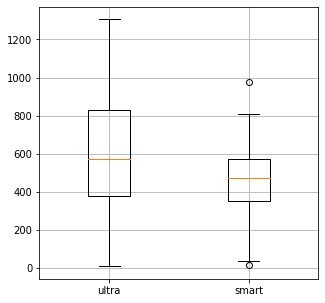

Услуга: Звонки     Гистограммы


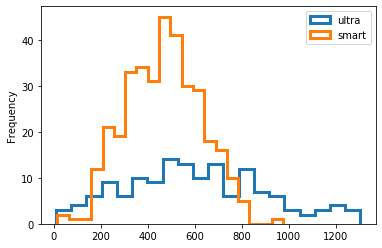

Услуга: Звонки   Тариф: ultra

Среднее значение по выборке: 603.76
Медианное значение по выборке: 573.5
Дисперсия: 86949.69
Стандартное отклонение: 294.87
Вероятность превышения лимита: 0.0
Доля пользователей, фактически превысивших лимит: 0.0

Услуга: Звонки   Тариф: smart

Среднее значение по выборке: 466.4
Медианное значение по выборке: 471.31
Дисперсия: 25227.57
Стандартное отклонение: 158.83
Вероятность превышения лимита: 0.3
Доля пользователей, фактически превысивших лимит: 0.31

Услуга: Сообщения     Диаграммы размаха


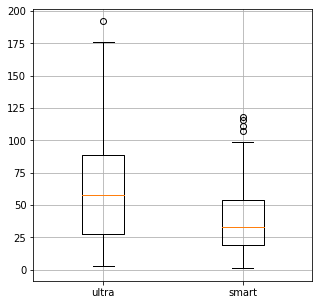

Услуга: Сообщения     Гистограммы


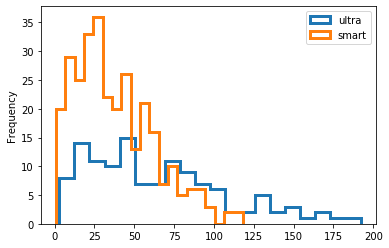

Услуга: Сообщения   Тариф: ultra

Среднее значение по выборке: 64.56
Медианное значение по выборке: 57.8
Дисперсия: 1867.56
Стандартное отклонение: 43.22
Вероятность превышения лимита: 0.0
Доля пользователей, фактически превысивших лимит: 0.0

Услуга: Сообщения   Тариф: smart

Среднее значение по выборке: 37.58
Медианное значение по выборке: 33.0
Дисперсия: 615.46
Стандартное отклонение: 24.81
Вероятность превышения лимита: 0.31
Доля пользователей, фактически превысивших лимит: 0.26

Услуга: Интернет     Диаграммы размаха


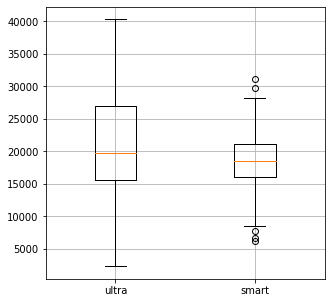

Услуга: Интернет     Гистограммы


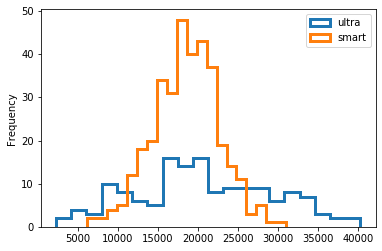

Услуга: Интернет   Тариф: ultra

Среднее значение по выборке: 20614.1
Медианное значение по выборке: 19719.54
Дисперсия: 72079872.42
Стандартное отклонение: 8489.99
Вероятность превышения лимита: 0.12
Доля пользователей, фактически превысивших лимит: 0.15

Услуга: Интернет   Тариф: smart

Среднее значение по выборке: 18556.5
Медианное значение по выборке: 18602.52
Дисперсия: 16801145.51
Стандартное отклонение: 4098.92
Вероятность превышения лимита: 0.78
Доля пользователей, фактически превысивших лимит: 0.79



In [58]:
# автоматизируем расчеты путем создания цикла:
for service in ['Звонки', 'Сообщения', 'Интернет']: # выбор таблицы в зависимости от услуги
    if service == 'Звонки':
        df=cpm
    if service == 'Сообщения':
        df=mpm
    if service=='Интернет':
        df=ipm
    df['mean'] = df.drop(columns=['user_id']).mean(axis=1) # расчет и добавление в таблицу среднемесячного значения
        
    print('Услуга:',service, '    Диаграммы размаха')
    plt.figure(figsize=(5,5)) # начало кода для вывода диаграмм размаха (по две диаграммы - оба тарифа - на одном поле)
    plt.hold = True
    boxes=[]
    for t in ['ultra','smart']:
        box = df[df['tariff']==t]['mean']
        boxes.append(box)
    plt.boxplot(boxes,labels=['ultra','smart'], widths=0.3)
    plt.grid()
    plt.show() # конец кода для вывода диаграмм размаха
    
    print('Услуга:',service,'    Гистограммы')
    for t in ['ultra','smart']: # построение гистограмм
        df[df['tariff']==t]['mean'].plot(kind='hist', y='mean', histtype='step', bins=20, linewidth=3, alpha=1, label=t, legend=True)
    plt.show()
    
    for t in ['ultra','smart']: # начало кода расчета и вывода на экран необходимых значений
        mean = df.query('tariff==@t')['mean'].mean().round(2) # среднее значение по выборке
        median = df.query('tariff==@t')['mean'].median().round(2) # медианное значение по выборке
        var = np.var(df[df['tariff']==t]['mean']).round(2) # дисперсия
        dev = np.std(df[df['tariff']==t]['mean']).round(2) # стандартное отклонение
        distr = st.norm(mean,dev) # задаем нормальное распределение
        if service =='Звонки' and t == 'ultra': # выбор значения лимита, включенного в абонентскую плату
            limit = 3000
        if service =='Звонки' and t == 'smart':
            limit = 550
        if service =='Сообщения' and t == 'ultra':
            limit = 1000
        if service =='Сообщения' and t == 'smart':
            limit = 50
        if service =='Интернет' and t == 'ultra':
            limit = 30720
        if service =='Интернет' and t == 'smart':
            limit = 15360
        excess_prob = (1-distr.cdf(limit)).round(2) # вероятность превышения лимита
        excess_nr = df.query('tariff == @t and mean > @limit')['user_id'].count() # число пользователей, фактически превысивших лимит
        tariff_total = df.query('tariff == @t')['user_id'].count() # число пользователей данного тарифа
        excess_actual = (excess_nr/tariff_total).round(2) # доля пользователей в выборке, фактически превысивших лимит
        print('Услуга:',service,'  Тариф:',t)
        print('')
        print('Среднее значение по выборке:',mean)
        print('Медианное значение по выборке:',median)
        print('Дисперсия:', var)
        print('Стандартное отклонение:' , dev)
        print('Вероятность превышения лимита:', excess_prob)
        print('Доля пользователей, фактически превысивших лимит:', excess_actual)
        print('') # конец кода расчета и вывода на экран необходимых значений

In [59]:
# процент пользователей каждого тарифа от общего числа пользователей в выборке
ultra_percent = (users.query('tariff == "ultra"')['user_id'].count()/users['user_id'].count()*100).round(1)
print('Процент количества пользователей тарифа Ультра в выборке:', ultra_percent)
smart_percent = (users.query('tariff == "smart"')['user_id'].count()/users['user_id'].count()*100).round(1)
print('Процент количества пользователей тарифа Смарт в выборке:', smart_percent)

Процент количества пользователей тарифа Ультра в выборке: 29.8
Процент количества пользователей тарифа Смарт в выборке: 70.2


### 3.2. Выводы статистического анализа

#### Вывод анализа продолжительности звонков

1. Среднемесячная суммарная продолжительность звонков на тарифе Смарт в среднем ниже, она составляет лишь 77% от продолжительности звонков на тарифе Ультра.
3. Пользователям тарифа Смарт требуется 466, Ультра - 604 минуты ежемесячно (среднее значение).
4. Вероятность превышения пользователями тарифа Смарт предоплаченного лимита минут - 0.30. Это согласуется с долей пользователей Смарт, фактически превысивших лимит - 0.31.  
Пользователи тарифа Ультра никогда не выходят за пределы предоплаченных 3000 минут, включенных в пакет.
5. Дисперсия и стандартное отклонение тарифа Смарт гораздо ниже, чем тарифа Ультра, несмотря на большее количество пользователей. Графики также показывают меньший разброс значений на тарифе Смарт. Это можно объяснить более низким лимитом, включенным в абонентскую плату.  
6. Распределения значений обоих тарифов являются нормальными.

#### Вывод анализа количества сообщений

1. Количество сообщений на тарифе Смарт в среднем ниже, оно составляет лишь 58% от количества сообщений на тарифе Ультра.
2. Пользователи тарифа Смарт отсылают 38, Ультра - 65 сообщений ежемесячно (среднее значение).
3.  Вероятность превышения пользователями тарифа Смарт предоплаченного лимита сообщений - 0.31. Это согласуется с долей пользователей Смарт, фактически превысивших лимит - 0.26, хотя и присутствует заметная разница. Эта разность объясняется тем, что вероятность мы рассчитывали исходя из нормального распределения, а фактически имеем распределением Пуассона.  
Пользователи тарифа Ультра никогда не выходят за пределы предоплаченных 1000 сообщений, включенных в пакет.
4. Дисперсия и стандартное отклонение тарифа Смарт гораздо ниже, чем тарифа Ультра, несмотря на большее количество пользователей. Графики также показывают меньший разброс значений на тарифе Смарт. Это можно объяснить более низким лимитом, включенным в абонентскую плату.  
5. Распределения значений обоих тарифов являются распределением Пуассона, стремящимся к нормальному со скосом вправо.

#### Вывод анализа интернет-трафика

1. Среднемесячный трафик на обоих тарифах различается незначительно.
2. Пользователям тарифа Смарт требуется 18.1, Ультра - 20.1 гигабайт ежемесячно (среднее значение).
3.  Вероятность превышения пользователями тарифа Смарт предоплаченного лимита интернет-трафика - 0.78. Это согласуется с долей пользователей Смарт, фактически превысивших лимит - 0.79. Медианный пользователь этого тарифа превышает предоплаченный трафик более чем на 3 гб, что обходится ему более чем в 600 р. ежемесячно.  
Вероятность превышения пользователями тарифа Ультра предоплаченного лимита интернет-трафика - 0.12. Это вполне согласуется с долей пользователей Ультра, фактически превысивших лимит - 0.15. Медианный пользователь этого тарифа не выходит за пределы предоплаченных 30 гб, включенных в пакет.  
4. Дисперсия и стандартное отклонение тарифа Смарт гораздо ниже, чем тарифа Ультра, несмотря на большее количество пользователей. Графики также показывают меньший разброс значений на тарифе Смарт. Это можно объяснить более низким лимитом, включенным в абонентскую плату.  
5. Распределения значений интернет-трафика на обоих тарифов - нормальные.

#### Общий вывод по статистическому анализу
1. Пользователи гораздо чаще выбирают тариф Смарт (70%), чем Ультра(30%).
2. Пользователям тарифа Смарт требуется пакет из 466 минуты звонков, 38 сообщений и 18.1 гб интернет-трафика ежемесячно (средние значения).  
Пользователям тарифа Ультра - 604 минут, 65 сообщений и 20.1 гб.
3. 31% пользователей тарифа Смарт превышают количество минут разговора, включенных в абоненсткую плату, 26% превышает лимит сообщений и 79% - лимит интернет-трафика (приведены доли, расчитанные по фактической выборке; вероятностные значения, как отмечено выше, незначительно отличаются).  
Пользователи тарифа Ультра всегда остаются в пределах пакета минут и сообщений, включенного в абонетскую плату, и лишь 15% превышают предоплаченный лимит интернет-трафика. 
4. Т.о., выручка тарифа Смарт складывается как из абонентской платы, так и платы за дополнительные минуты, сообщения и гигабайты.  
Выручка тарифа Ультра состоит прежде всего из абонентской платы и (для 15% пользователей) платы за дополнительный интернет-трафик.  

### 4. Проверка гипотез

### 4.1. Сравнение выручки с тарифов Ультра и Смарт.

Сформулируем нулевую гипотезу так, чтобы использовать знак равенства. Альтернативная гипотеза формулируется исходя из нулевой. 

Нулевая гипотеза:  
Средняя выручка тарифа Ультра равна средней выручке тарифа Смарт.  
Альтернативная гипотеза:  
Средняя выручка тарифа Ультра не равна средней выручке тарифа Смарт.

В качестве критерия для проверки гипотезы будем использовать среднемесячное значение выручки с каждого пользователя.

Будем работать с таблицей 'income', содержащей информацию о суммарных ежемесячных платежах каждого пользователя и название его тарифа, в которую добавим столбец со значениями среднемесячной выручки с каждого клиента по отдельности.

In [60]:
# добавим столбец со значениями среднемесячной выручки с каждого клиента по отдельности
income['mean'] = income.drop(columns=['user_id']).mean(axis=1).round(2)
income.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,mean
0,1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,ultra,1950.00
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1750.0,750.0,smart,1250.00
2,1002,NaN,NaN,NaN,NaN,NaN,550.0,1950.0,2150.0,1550.0,750.0,1950.0,1750.0,smart,1521.43
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,ultra,1950.00
4,1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,ultra,1950.00


In [61]:
# срезы таблицы 'income' (выручка) по тарифам:
income_ultra=income.query('tariff=="ultra"')
income_smart=income.query('tariff=="smart"')

In [62]:
# дисперсия среднемесячной выручки по тарифам
var_ultra = np.var(income_ultra['mean']).round(2)
var_smart = np.var(income_smart['mean']).round(2)
print('Дисперсия выручки    Тариф Ультра:', var_ultra)
print('Дисперсия выручки    Тариф Смарт:', var_smart)

Дисперсия выручки    Тариф Ультра: 124298.37
Дисперсия выручки    Тариф Смарт: 611394.98


Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей (тарифы Ультра и Смарт) по взятым из них выборкам, проведем статистический тест - применим метод scipy.stats.ttest_ind() . Методу передадим параметры: income_ultra['mean'] и income_smart['mean'] - массивы, содержащие выборки. Параметру equal_var передадим значение False, т.к. дисперсии выборок отличаются значительно.

In [63]:
tariff_alpha = 0.05 # критический уровень статистической значимости
tariff_result = st.ttest_ind(income_ultra['mean'],income_smart['mean'], equal_var=False) # статистический тест
tariff_beta = tariff_result.pvalue # p-value - вероятность получить предполагаемый результат при условии, что нулевая гипотеза верна:
print('p-значение: ',tariff_beta ) 
if (tariff_beta < tariff_alpha):
    print("Отвергаем нулевую гипотезу, т.е. средняя выручка тарифа Ультра не равна средней выручке тарифа Смарт.")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.9550632907117335e-12
Отвергаем нулевую гипотезу, т.е. средняя выручка тарифа Ультра не равна средней выручке тарифа Смарт.


Близкое к нулю р-значение означает практически нулевую вероятность того, что выручка разных тарифов окажется одинаковой.

In [64]:
# средние и медианные значения среднемесячной выручки 
ultra_mean = income_ultra['mean'].mean().round(2)
ultra_median = income_ultra['mean'].median().round(2)
smart_mean = income_smart['mean'].mean().round(2)
smart_median = income_smart['mean'].median().round(2)
print('Тариф Ультра')
print('')
print('Средняя выручка с одного клиента в месяц:',ultra_mean)
print('Медианная выручка с одного клиента в месяц:',ultra_median)
print('')
print('Тариф Смарт')
print('')
print('Средняя выручка с одного клиента в месяц:',smart_mean)
print('Медианная выручка с одного клиента в месяц:',smart_median)

Тариф Ультра

Средняя выручка с одного клиента в месяц: 2124.19
Медианная выручка с одного клиента в месяц: 1950.0

Тариф Смарт

Средняя выручка с одного клиента в месяц: 1763.32
Медианная выручка с одного клиента в месяц: 1681.94


Cудя по средним и медианным значениям тариф Ультра является более выгодным для оператора, чем тариф Смарт. Однако, надо учесть, что тариф Смарт гораздо более популярен, чем Ультра. Посчитаем ожидаемую выручку с данной выборки клиентов за месяц.

In [65]:
income_month_ultra = (ultra_median*users[users['tariff']=='ultra']['user_id'].count()).round(2)
income_month_smart = (smart_median*users[users['tariff']=='smart']['user_id'].count()).round(2)
print('Ожидаемая ежемесячная суммарная выручка   Ультра:',income_month_ultra)
print('Ожидаемая ежемесячная суммарная выручка   Смарт:',income_month_smart)

Ожидаемая ежемесячная суммарная выручка   Ультра: 290550.0
Ожидаемая ежемесячная суммарная выручка   Смарт: 590360.94


#### Вывод сравнения тарифов

Тариф Смарт по сравнению с тарифом Ультра более популярен среди клиентов и благодаря этому приносит бОльшую суммарную выручку, несмотря на меньшее значение среднемесячной выручки, получаемой с одного клиента.

### 4.2. Сравнение выручки Москвы и других городов.

Сформулируем нулевую гипотезу так, чтобы использовать знак равенства. Альтернативная гипотеза формулируется исходя из нулевой. 

Нулевая гипотеза:  
Средняя выручка с пользователей из Москвы равна средней выручке с пользователей из других регионов.  
Альтернативная гипотеза:  
Средняя выручка с пользователей из Москвы не равна средней выручке с пользователей из других регионов.

В качестве критерия для проверки гипотезы будем использовать среднемесячное значение выручки с каждого пользователя.

Будем работать с таблицей 'income', содержащей информацию о название тарифа и значении среднемесячной выручки с каждого клиента, в которую добавим столбец с информацией о городе проживания.

In [66]:
# в таблицу 'income' добавим столбец с информацией о городе проживания клиента
income=income.join(users1['city'], on='user_id')
income.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,mean,city
0,1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,ultra,1950.00,Краснодар
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1750.0,750.0,smart,1250.00,Москва
2,1002,NaN,NaN,NaN,NaN,NaN,550.0,1950.0,2150.0,1550.0,750.0,1950.0,1750.0,smart,1521.43,Стерлитамак
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,ultra,1950.00,Москва
4,1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,ultra,1950.00,Новокузнецк


In [67]:
# срезы таблицы 'income' (выручка) по Москве и другим городам:
income_msk=income.query('city=="Москва"')
income_other=income.query('city!="Москва"')

In [68]:
# дисперсия среднемесячной выручки по Москве и другим городам
var_msk = np.var(income_msk['mean']).round(2)
var_other = np.var(income_other['mean']).round(2)
print('Дисперсия выручки    Москва:', var_msk)
print('Дисперсия выручки    другие:', var_other)

Дисперсия выручки    Москва: 418673.58
Дисперсия выручки    другие: 510908.22


Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей (пользователи Москвы, пользователи из других городов) по взятым из них выборкам, проведем статистический тест - применим метод scipy.stats.ttest_ind() . Методу передадим параметры: income_msk['mean'] и income_other['mean'] - массивы, содержащие выборки. Параметру equal_var передадим значение True, т.к. дисперсии выборок отличаются незначительно.

In [69]:
city_alpha = 0.05 # критический уровень статистической значимости
city_result = st.ttest_ind(income_msk['mean'],income_other['mean'], equal_var=True) # статистический тест
city_beta = city_result.pvalue # p-value - вероятность получить предполагаемый результат при условии, что нулевая гипотеза верна:
print('p-значение: ',city_beta ) 
if (city_beta < city_alpha):
    print("Отвергаем нулевую гипотезу, т.е. средняя выручка Москвы не равна средней выручке других городов.")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.25997962602626984
Не получилось отвергнуть нулевую гипотезу


Р-значение, равное 0.26, говорит о том, что, с вероятностью 26% средняя выручка по Москве может оказаться равной выручке по другим городам. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между этими двумя группами клиентов.

In [70]:
# средние и медианные значения среднемесячной выручки 
msk_mean = income_msk['mean'].mean().round(2)
msk_median = income_msk['mean'].median().round(2)
other_mean = income_other['mean'].mean().round(2)
other_median = income_other['mean'].median().round(2)
print('Москва')
print('')
print('Средняя выручка с одного клиента в месяц:',msk_mean)
print('Медианная выручка с одного клиента в месяц:',msk_median)
print('')
print('Другие города')
print('')
print('Средняя выручка с одного клиента в месяц:',other_mean)
print('Медианная выручка с одного клиента в месяц:',other_median)

Москва

Средняя выручка с одного клиента в месяц: 1799.22
Медианная выручка с одного клиента в месяц: 1950.0

Другие города

Средняя выручка с одного клиента в месяц: 1888.27
Медианная выручка с одного клиента в месяц: 1950.0


#### Вывод сравнения выручки Москвы и других городов

Средняя выручка по Москве и по другим городам неодинакова, но отличие незначительно (1799 и 1888 р.). С вероятностью в 26% такое различие можно получить случайно.

### 5. Общий вывод

1. Пользователям тарифа Смарт требуется пакет из 466 минуты звонков, 38 сообщений и 18.1 гб интернет-трафика ежемесячно (средние значения).  
Пользователям тарифа Ультра - 604 минут, 65 сообщений и 20.1 гб.
2. 31% пользователей тарифа Смарт превышают количество минут разговора, включенных в абоненсткую плату, 26% превышает лимит сообщений и 79% - лимит интернет-трафика (приведены доли, расчитанные по фактической выборке; вероятностные значения незначительно отличаются).  
Пользователи тарифа Ультра всегда остаются в пределах пакета минут и сообщений, включенного в абонетскую плату, и лишь 15% из них превышают предоплаченный лимит интернет-трафика. 
3. Т.о., выручка тарифа Смарт складывается как из абонентской платы, так и платы за дополнительные минуты, сообщения и гигабайты.  
Выручка тарифа Ультра состоит прежде всего из абонентской платы и (для 15% пользователей) платы за дополнительный интернет-трафик.
4. Пользователи гораздо чаще выбирают тариф Смарт (70%), чем Ультра(30%). Благодаря этому тариф Смарт приносит бОльшую суммарную выручку, несмотря на меньшее значение среднемесячной выручки, получаемой с одного клиента.
5. Среднемесячная выручка с одного клиента тарифа Ультра больше, чем выручка с клиента тарифа Смарт. Это различие не является случайным.
6. Средняя выручка по Москве и по другим городам неодинакова, но отличие незначительно. С вероятностью в 26% такое различие можно получить случайно.